In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, cv, DMatrix
from catboost import CatBoostRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import math

In [3]:
file_path = 'elektriktuketim.xlsx'
energy_df = pd.read_excel(file_path, sheet_name='başkent enerji tüketimi')
weather_df = pd.read_excel(file_path, sheet_name='hava durumu')
energy_df.head()

Date     00:00:00     01:00:00     02:00:00     03:00:00     04:00:00  \
0 2022-01-01  1790.603437  1676.168012  1550.834591  1460.261913  1413.840536   
1 2022-01-02  1722.672590  1562.061367  1453.164297  1393.565091  1363.033421   
2 2022-01-03  1746.107250  1595.924327  1504.951518  1458.757938  1440.622675   
3 2022-01-04  1790.151738  1646.581872  1554.530486  1513.504212  1506.423895   
4 2022-01-05  1796.472395  1645.095757  1568.280433  1524.143103  1519.959143   

      05:00:00     06:00:00     07:00:00     08:00:00  ...     14:00:00  \
0  1401.456888  1427.704213  1477.118203  1453.508096  ...  2128.875204   
1  1375.042749  1402.548597  1463.864439  1467.662114  ...  2101.667923   
2  1460.940898  1567.647226  1847.684113  2176.475927  ...  2566.295618   
3  1524.419877  1623.290384  1872.807812  2186.881883  ...  2513.429559   
4  1548.354280  1642.190854  1889.786956  2211.342106  ...  2439.385855   

      15:00:00     16:00:00     17:00:00     18:00:00     19:00:00  \
0  2104.077508  2085.508515  2186.072963  2296.534242  2227.576793   
1  2064.567813  2062.629525  2177.752182  2341.862008  2306.330863   
2  2480.076177  2466.303364  2521.395505  2538.920813  2440.117552   
3  2443.241053  2420.547250  2483.733767  2525.264160  2434.584568   
4  2370.047304  2369.421795  2449.988900  2508.836409  2418.013841   

      20:00:00     21:00:00     22:00:00     23:00:00  
0  2148.180590  2048.926155  1957.918116  1868.951666  
1  2234.784201  2138.905322  2041.204498  1910.553853  
2  2339.947052  2227.322129  2102.544882  1965.485352  
3  2351.267333  2235.188878  2113.145026  1967.219971  
4  2339.841197  2233.122069  2114.862248  1971.049768  

[5 rows x 25 columns]

In [4]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      846 non-null    datetime64[ns]
 1   00:00:00  846 non-null    float64       
 2   01:00:00  846 non-null    float64       
 3   02:00:00  846 non-null    float64       
 4   03:00:00  846 non-null    float64       
 5   04:00:00  846 non-null    float64       
 6   05:00:00  846 non-null    float64       
 7   06:00:00  846 non-null    float64       
 8   07:00:00  846 non-null    float64       
 9   08:00:00  846 non-null    float64       
 10  09:00:00  846 non-null    float64       
 11  10:00:00  846 non-null    float64       
 12  11:00:00  846 non-null    float64       
 13  12:00:00  846 non-null    float64       
 14  13:00:00  846 non-null    float64       
 15  14:00:00  846 non-null    float64       
 16  15:00:00  846 non-null    float64       
 17  16:00:00  846 no

In [5]:
weather_df.head()

Date                Data 00:00:00 01:00:00         02:00:00 03:00:00  \
0 2022-01-01      AirTemperature      4.5      3.9              3.4      2.8   
1 2022-01-01  ComfortTemperature      4.2      3.7              3.2      2.6   
2 2022-01-01    RelativeHumidity     80.9     82.6             82.5     84.8   
3 2022-01-01   Weather Condition      Sis  Bulutlu  Parçalı Bulutlu      Sis   
4 2022-01-01       WindDirection        0        0                0        0   

  04:00:00 05:00:00 06:00:00 07:00:00  ... 14:00:00         15:00:00 16:00:00  \
0      2.5      2.5      2.3      2.1  ...      5.7              6.7      6.5   
1      2.3      2.3      2.1        2  ...      5.4              6.4      6.2   
2     85.4     85.4     86.6     86.6  ...     81.6             77.8     78.9   
3      Sis      Sis      Sis      Sis  ...   Yağmur  Parçalı Bulutlu      Sis   
4        0        0        0        0  ...      220              220      250   

  17:00:00 18:00:00 19:00:00 20:00:00 21:00:00 22:00:00         23:00:00  
0      6.5      6.1      5.6      5.5      5.4        5                5  
1      6.2      5.9      5.4      5.3      5.2      4.9              4.9  
2     78.9     82.8     87.6     90.7     91.3     96.6             96.6  
3      Sis   Yağmur   Yağmur   Yağmur   Yağmur   Yağmur  Parçalı Bulutlu  
4        0      190      180        0      190      190                0  

[5 rows x 26 columns]

In [6]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5082 non-null   datetime64[ns]
 1   Data      5082 non-null   object        
 2   00:00:00  5082 non-null   object        
 3   01:00:00  5082 non-null   object        
 4   02:00:00  5082 non-null   object        
 5   03:00:00  5082 non-null   object        
 6   04:00:00  5082 non-null   object        
 7   05:00:00  5082 non-null   object        
 8   06:00:00  5082 non-null   object        
 9   07:00:00  5082 non-null   object        
 10  08:00:00  5082 non-null   object        
 11  09:00:00  5082 non-null   object        
 12  10:00:00  5082 non-null   object        
 13  11:00:00  5082 non-null   object        
 14  12:00:00  5082 non-null   object        
 15  13:00:00  5082 non-null   object        
 16  14:00:00  5082 non-null   object        
 17  15:00:00  5082

In [7]:
print("weather", weather_df.shape)
print("energy", weather_df.shape)

weather (5082, 26)
energy (5082, 26)


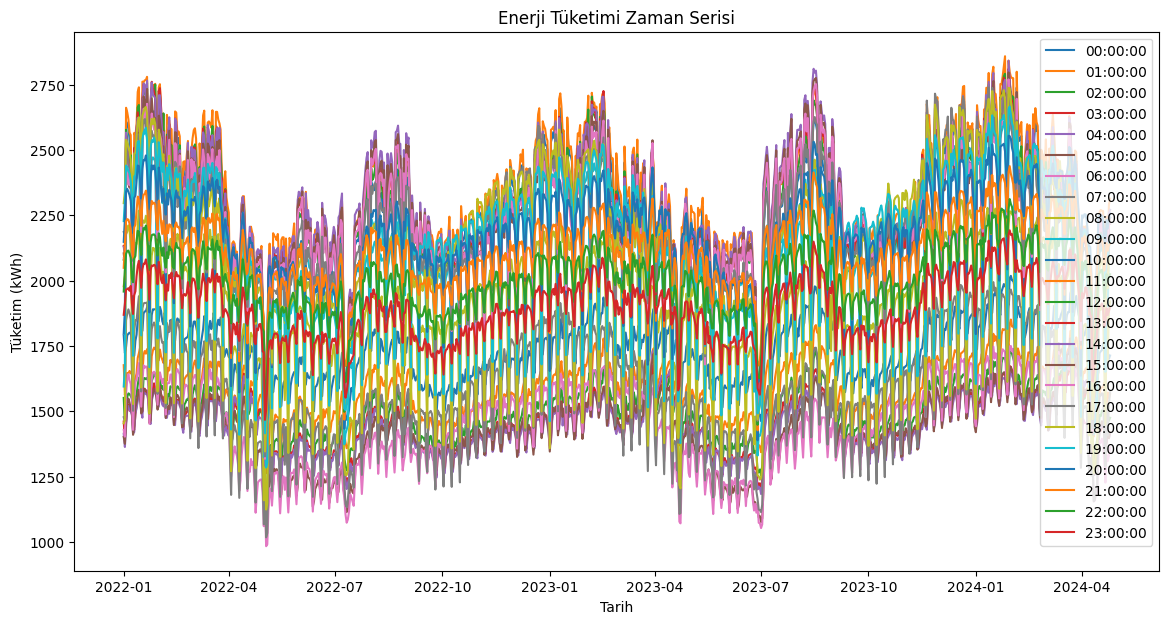

In [8]:
plt.figure(figsize=(14, 7))
for col in energy_df.columns[1:]:
    plt.plot(energy_df['Date'], energy_df[col], label=col)
plt.title('Enerji Tüketimi Zaman Serisi')
plt.xlabel('Tarih')
plt.ylabel('Tüketim (kWh)')
plt.legend(loc='upper right')
plt.show()

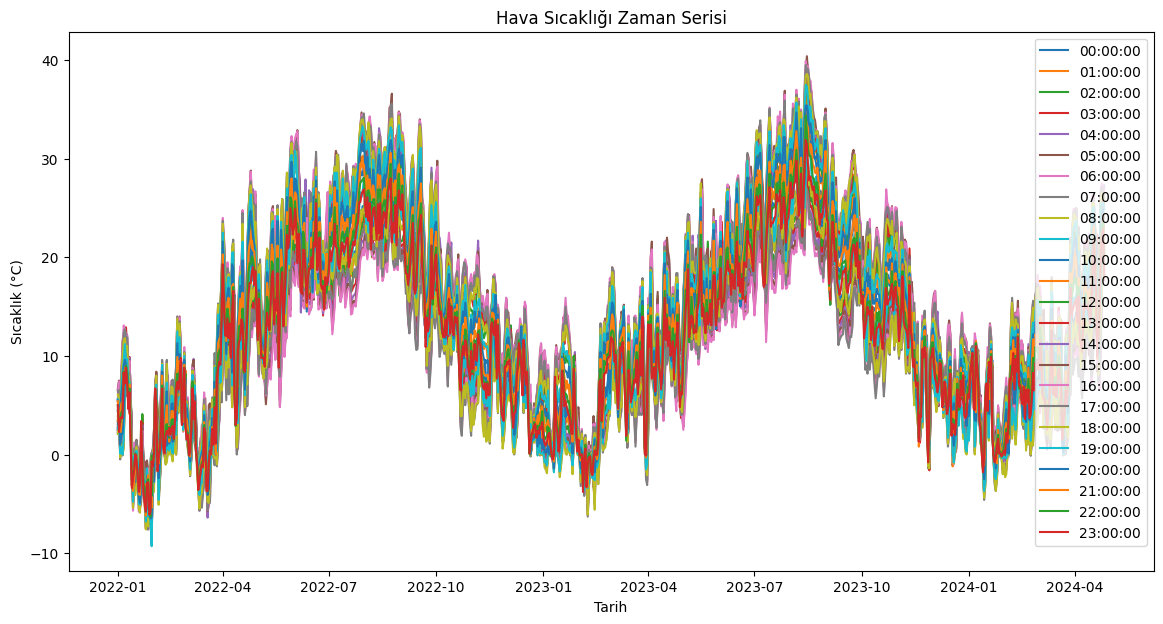

In [9]:
plt.figure(figsize=(14, 7))
air_temp = weather_df[weather_df['Data'] == 'AirTemperature']
for col in air_temp.columns[2:]:
    plt.plot(air_temp['Date'], air_temp[col], label=col)
plt.title('Hava Sıcaklığı Zaman Serisi')
plt.xlabel('Tarih')
plt.ylabel('Sıcaklık (°C)')
plt.legend(loc='upper right')
plt.show()

In [10]:
merged_df = pd.merge(energy_df, weather_df, on='Date', how='inner')
print("merged_df shape = ", merged_df.shape)
merged_df.info()

merged_df shape =  (5076, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5076 entries, 0 to 5075
Data columns (total 50 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5076 non-null   datetime64[ns]
 1   00:00:00_x  5076 non-null   float64       
 2   01:00:00_x  5076 non-null   float64       
 3   02:00:00_x  5076 non-null   float64       
 4   03:00:00_x  5076 non-null   float64       
 5   04:00:00_x  5076 non-null   float64       
 6   05:00:00_x  5076 non-null   float64       
 7   06:00:00_x  5076 non-null   float64       
 8   07:00:00_x  5076 non-null   float64       
 9   08:00:00_x  5076 non-null   float64       
 10  09:00:00_x  5076 non-null   float64       
 11  10:00:00_x  5076 non-null   float64       
 12  11:00:00_x  5076 non-null   float64       
 13  12:00:00_x  5076 non-null   float64       
 14  13:00:00_x  5076 non-null   float64       
 15  14:00:00_x  5076 non-null   float64       

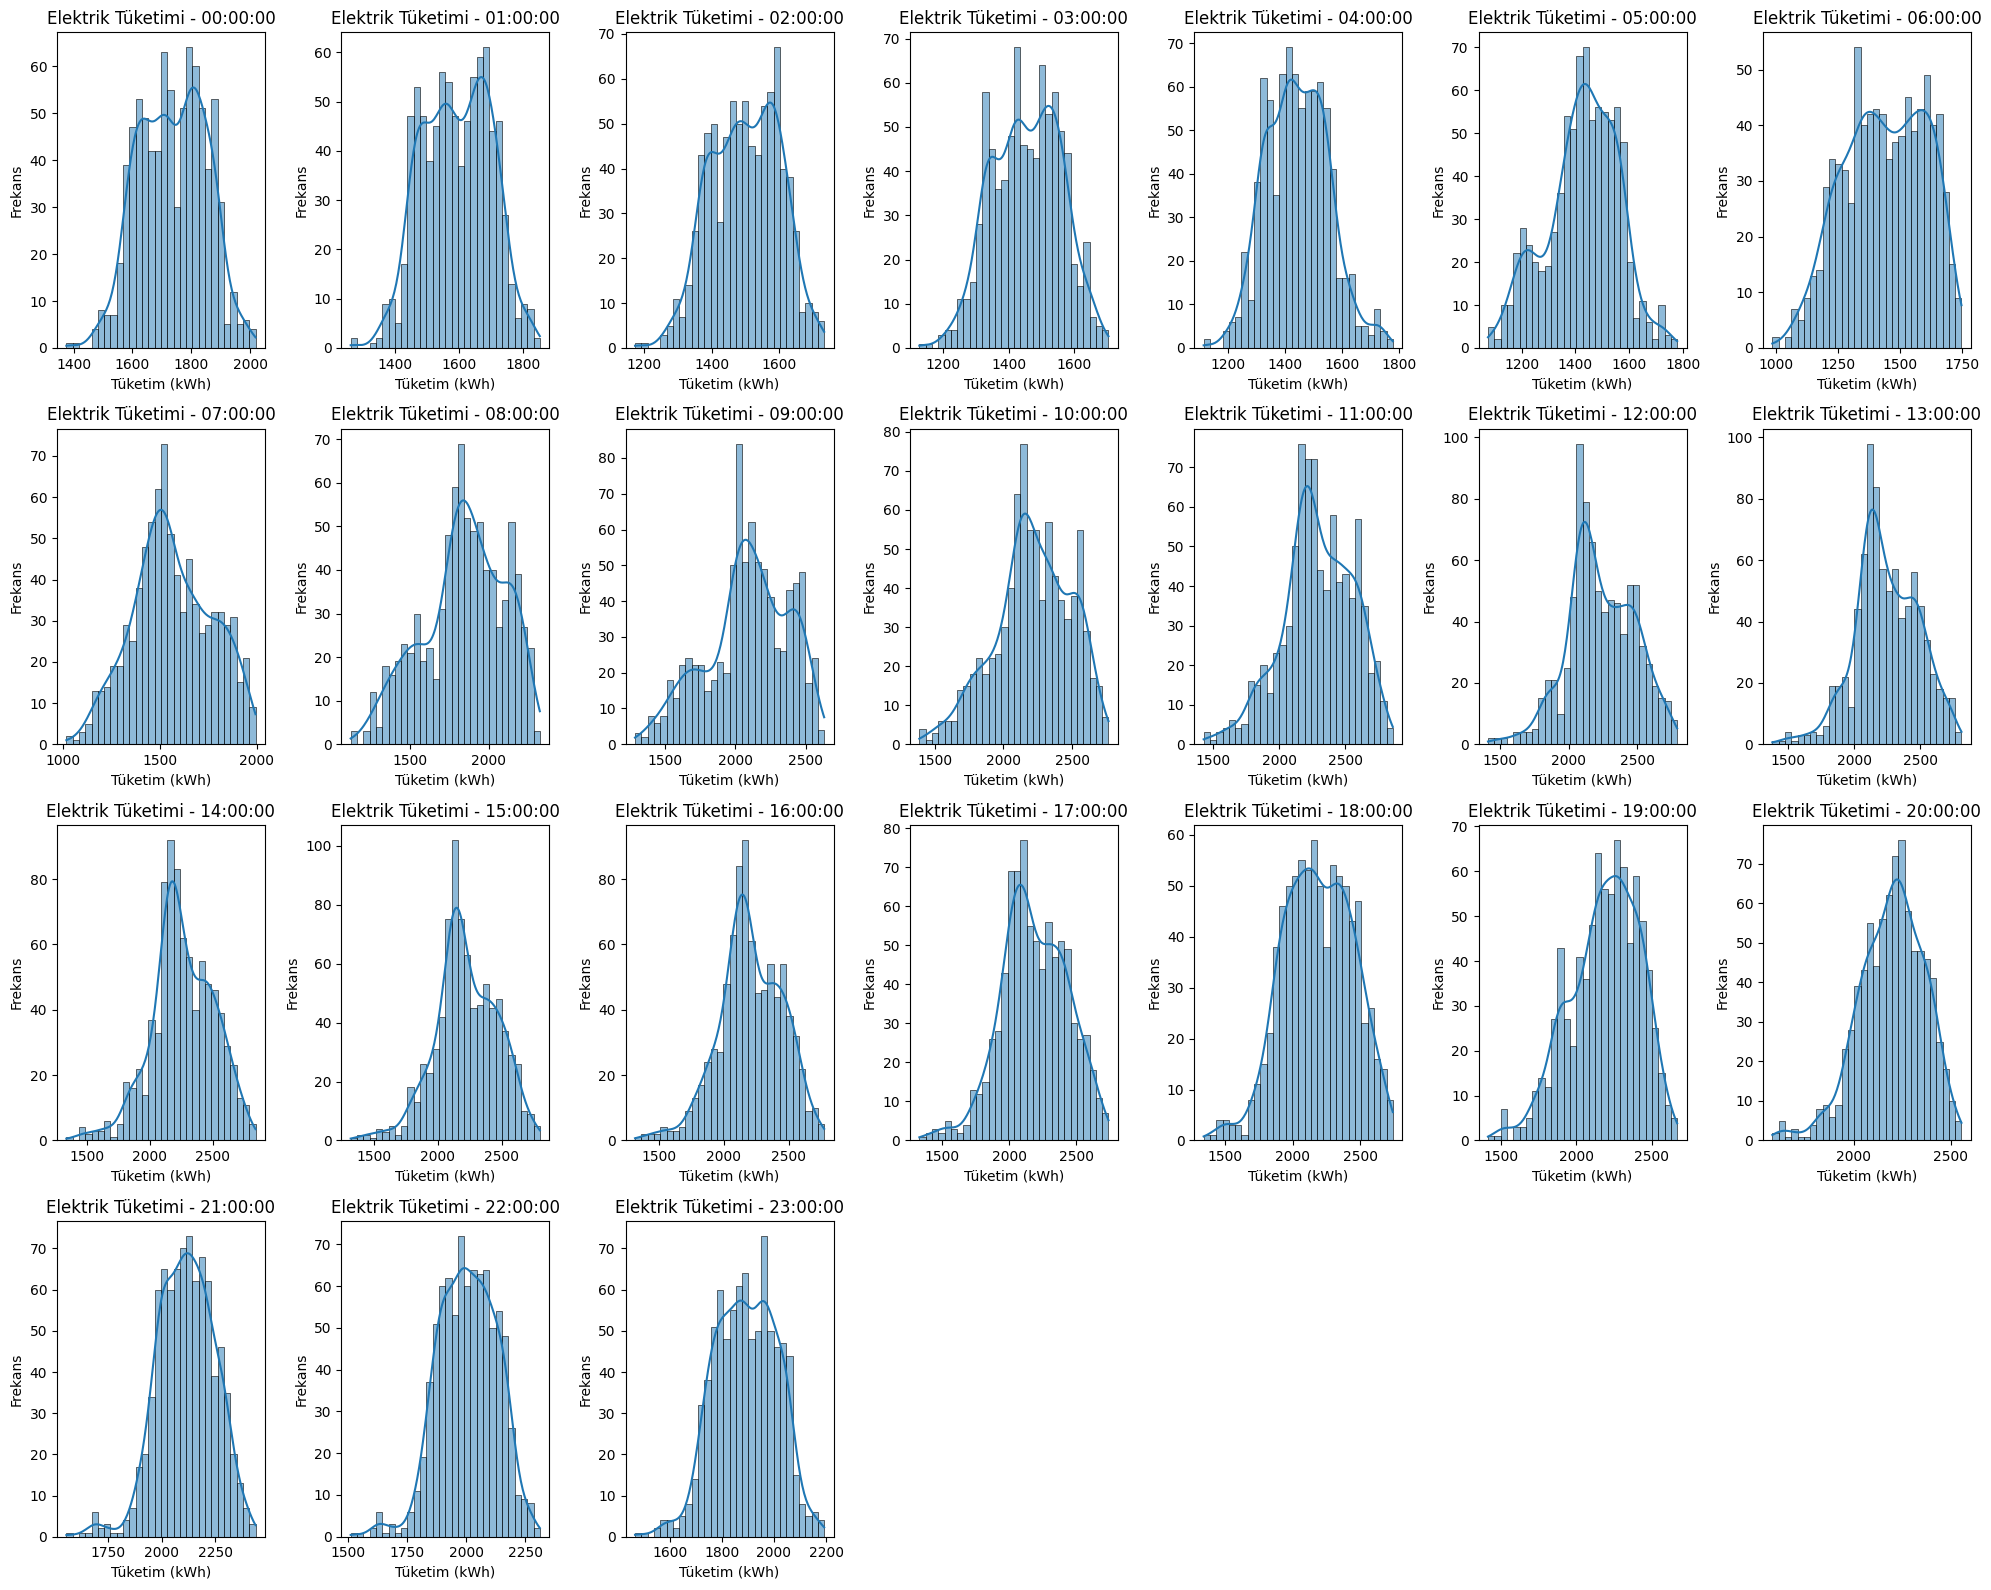

In [11]:
hourly_columns = energy_df.columns[1:]

num_hours = len(hourly_columns)
num_cols = 7  
num_rows = (num_hours + num_cols - 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()  

for i, col in enumerate(hourly_columns):
    sns.histplot(energy_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Elektrik Tüketimi - {col}')
    axes[i].set_xlabel('Tüketim (kWh)')
    axes[i].set_ylabel('Frekans')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
weather_conditions = weather_df[weather_df['Data'] == 'Weather Condition']
unique_conditions = weather_conditions.iloc[:, 2:].stack().unique()

condition_mapping = {condition: idx for idx, condition in enumerate(unique_conditions)}

print("Hava Durumu Koşulları ve Sayısal Değerler:")
print(condition_mapping)

def map_conditions(row):
    if row['Data'] == 'Weather Condition':
        return row[2:].map(condition_mapping)
    else:
        return row[2:]

weather_df.iloc[:, 2:] = weather_df.apply(map_conditions, axis=1)

Hava Durumu Koşulları ve Sayısal Değerler:
{'Sis': 0, 'Bulutlu': 1, 'Parçalı Bulutlu': 2, 'Yağmur': 3, 'Açık': 4, 'Kar': 5, 'Karla Karışık Yağmur': 6, 'Çisenti': 7, 'Fırtına': 8, 'Dolu': 9}


/var/folders/rj/h2nk4rh52qggh_4n23q9sxsm0000gn/T/ipykernel_58051/1446900901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_df['Average Temperature'] = temperature_df.drop(columns=['Date', 'Data']).mean(axis=1)


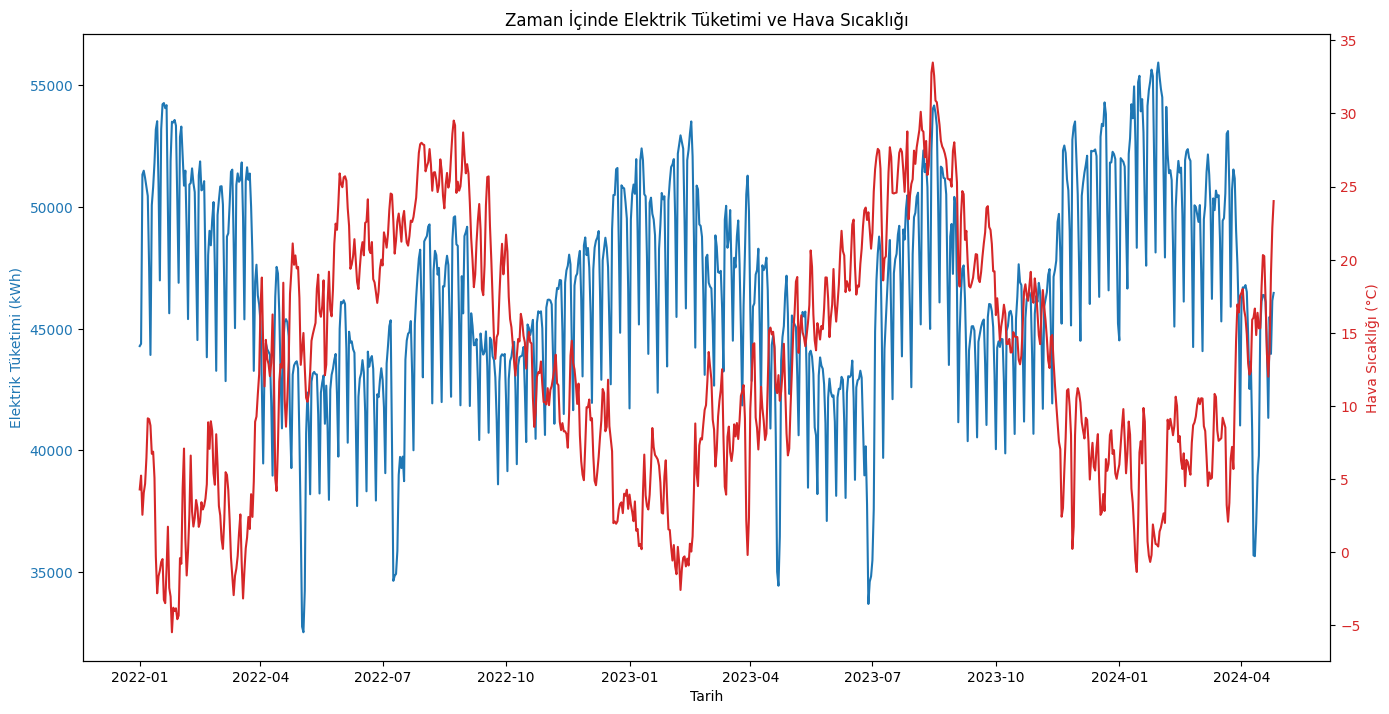

In [13]:
temperature_df = weather_df[weather_df['Data'] == 'AirTemperature']

energy_df['Total Consumption'] = energy_df.drop(columns=['Date']).sum(axis=1)

temperature_df['Average Temperature'] = temperature_df.drop(columns=['Date', 'Data']).mean(axis=1)

merged_df = pd.merge(energy_df[['Date', 'Total Consumption']], temperature_df[['Date', 'Average Temperature']], on='Date')

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Tarih')
ax1.set_ylabel('Elektrik Tüketimi (kWh)', color=color)
ax1.plot(merged_df['Date'], merged_df['Total Consumption'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Hava Sıcaklığı (°C)', color=color)
ax2.plot(merged_df['Date'], merged_df['Average Temperature'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.title('Zaman İçinde Elektrik Tüketimi ve Hava Sıcaklığı')
plt.show()

In [14]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Kış'
    elif month in [3, 4, 5]:
        return 'İlkbahar'
    elif month in [6, 7, 8]:
        return 'Yaz'
    else:
        return 'Sonbahar'

merged_df['Season'] = merged_df['Date'].apply(get_season)

seasons = merged_df['Season'].unique()
colors = {'Kış': 'tab:blue', 'İlkbahar': 'tab:green', 'Yaz': 'tab:orange', 'Sonbahar': 'tab:red'}

fig, ax1 = plt.subplots(figsize=(14, 8))

for season in seasons:
    season_df = merged_df[merged_df['Season'] == season]
    ax1.plot(season_df['Date'], season_df['Total Consumption'], label=f'{season} - Elektrik Tüketimi', color=colors[season])

ax1.set_xlabel('Tarih')
ax1.set_ylabel('Elektrik Tüketimi (kWh)')
ax1.legend(loc='upper left')
ax1.set_title('Mevsimlere Göre Elektrik Tüketimi ve Hava Sıcaklığı')

ax2 = ax1.twinx() 
for season in seasons:
    season_df = merged_df[merged_df['Season'] == season]
    ax2.plot(season_df['Date'], season_df['Average Temperature'], label=f'{season} - Hava Sıcaklığı', linestyle='--', color=colors[season])

ax2.set_ylabel('Hava Sıcaklığı (°C)')
ax2.legend(loc='upper right')

fig.tight_layout() 
plt.show()

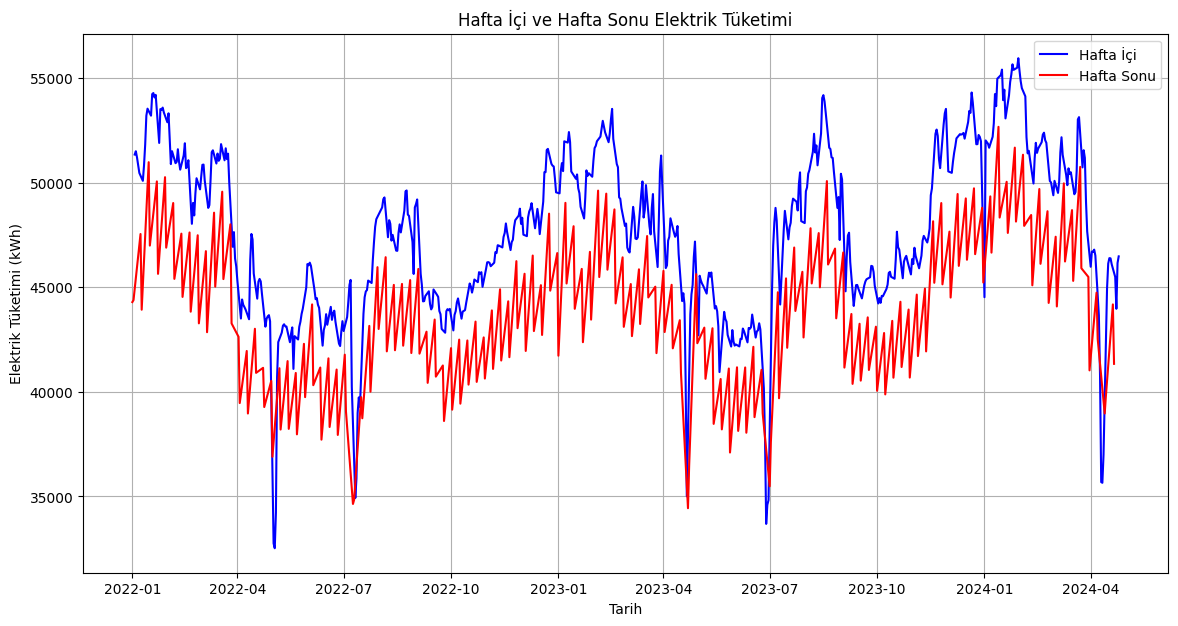

In [15]:
energy_df['Day Type'] = energy_df['Date'].dt.dayofweek.apply(lambda x: 'Hafta İçi' if x < 5 else 'Hafta Sonu')

weekdays_df = energy_df[energy_df['Day Type'] == 'Hafta İçi']
weekends_df = energy_df[energy_df['Day Type'] == 'Hafta Sonu']

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(weekdays_df['Date'], weekdays_df['Total Consumption'], label='Hafta İçi', color='blue')

ax.plot(weekends_df['Date'], weekends_df['Total Consumption'], label='Hafta Sonu', color='red')

ax.set_xlabel('Tarih')
ax.set_ylabel('Elektrik Tüketimi (kWh)')
ax.set_title('Hafta İçi ve Hafta Sonu Elektrik Tüketimi')
ax.legend()
ax.grid(True)

plt.show()

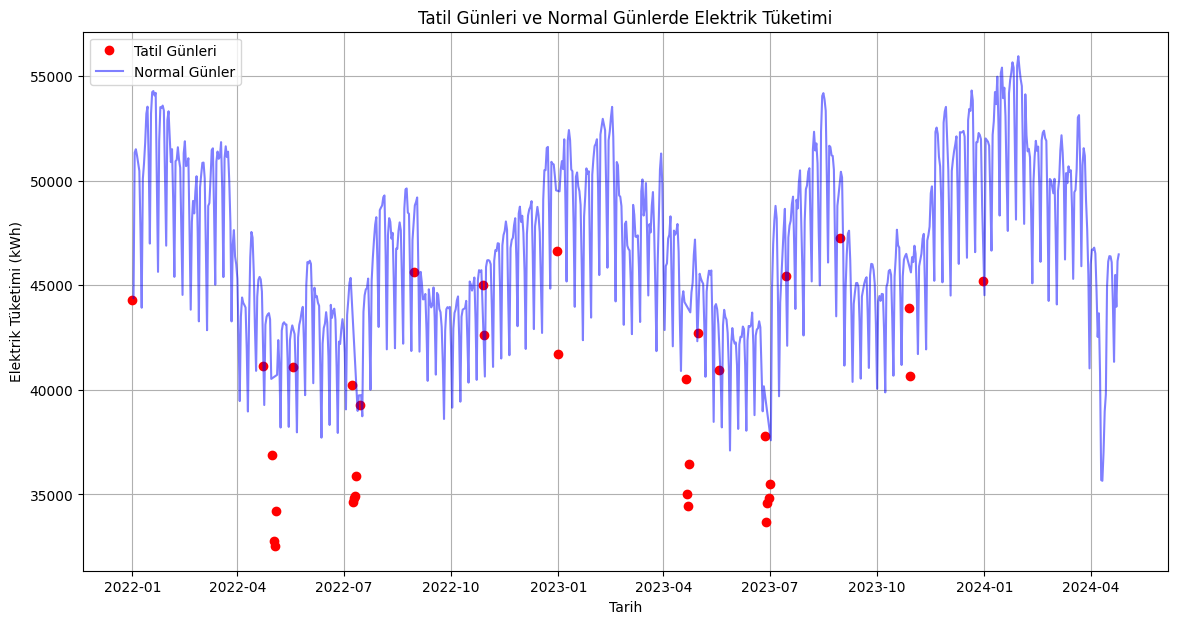

In [16]:
public_holidays_2022 = [
    '2022-01-01', '2022-04-23', '2022-05-01', '2022-05-02', '2022-05-03', '2022-05-04',
    '2022-05-19', '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11', '2022-07-12',
    '2022-07-15', '2022-08-30', '2022-10-28', '2022-10-29', '2022-12-31'
]
public_holidays_2023 = [
    '2023-01-01', '2023-04-20', '2023-04-21', '2023-04-22', '2023-04-23', '2023-05-01',
    '2023-05-19', '2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30', '2023-07-01',
    '2023-07-15', '2023-08-30', '2023-10-28', '2023-10-29', '2023-12-31'
]
public_holidays = pd.to_datetime(public_holidays_2022 + public_holidays_2023)

energy_df['Holiday'] = energy_df['Date'].isin(public_holidays)

holiday_df = energy_df[energy_df['Holiday'] == True]
non_holiday_df = energy_df[energy_df['Holiday'] == False]

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(holiday_df['Date'], holiday_df['Total Consumption'], label='Tatil Günleri', color='red', marker='o', linestyle='None')

ax.plot(non_holiday_df['Date'], non_holiday_df['Total Consumption'], label='Normal Günler', color='blue', alpha=0.5)

ax.set_xlabel('Tarih')
ax.set_ylabel('Elektrik Tüketimi (kWh)')
ax.set_title('Tatil Günleri ve Normal Günlerde Elektrik Tüketimi')
ax.legend()
ax.grid(True)

plt.show()

In [17]:
merged_df.describe().T

count                 mean                  min  \
Date                 846  2023-02-27 12:00:00  2022-01-01 00:00:00   
Total Consumption  846.0         46514.692152         32524.558708   

                                   25%                  50%  \
Date               2022-07-31 06:00:00  2023-02-27 12:00:00   
Total Consumption         43710.576179         46353.475744   

                                   75%                  max          std  
Date               2023-09-26 18:00:00  2024-04-25 00:00:00          NaN  
Total Consumption         49908.007888         55939.637151  4238.126105

In [18]:
df = merged_df.copy()

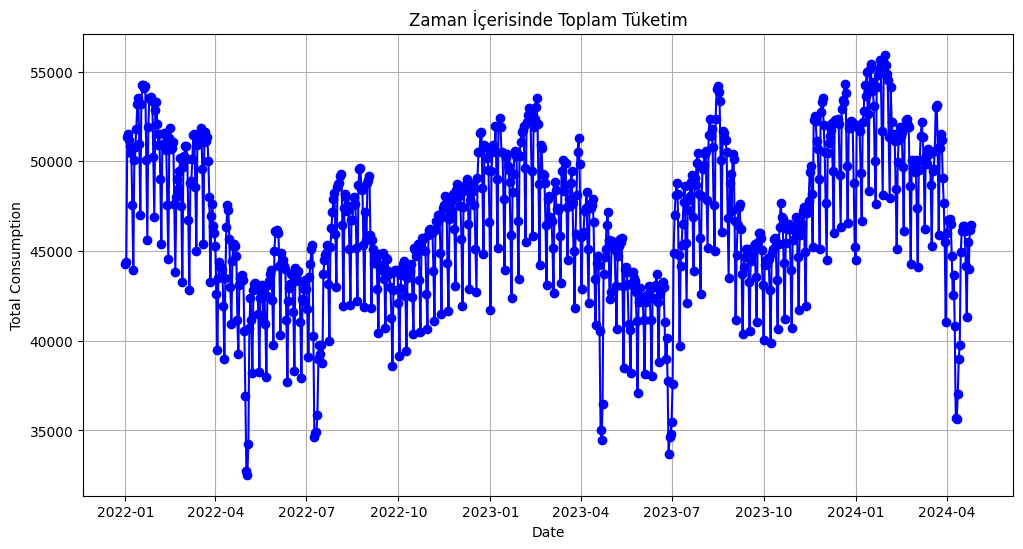

In [19]:
df.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Total Consumption'], marker='o', linestyle='-', color='b')
plt.title('Zaman İçerisinde Toplam Tüketim')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.grid(True)
plt.show()

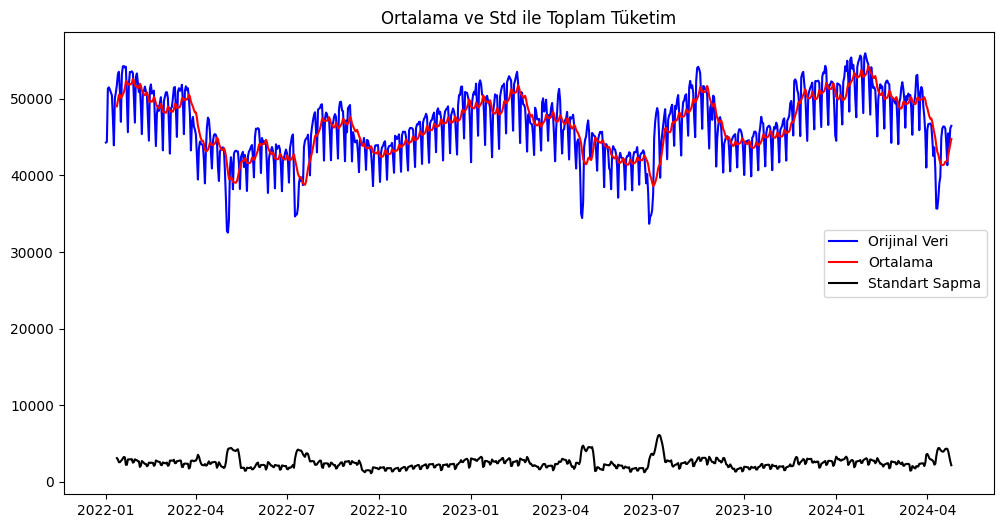

In [20]:
rolling_mean = df['Total Consumption'].rolling(window=12).mean()
rolling_std = df['Total Consumption'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(df['Total Consumption'], color='blue', label='Orijinal Veri')
plt.plot(rolling_mean, color='red', label='Ortalama')
plt.plot(rolling_std, color='black', label='Standart Sapma')
plt.title('Ortalama ve Std ile Toplam Tüketim')
plt.legend(loc='best')
plt.show()

/var/folders/rj/h2nk4rh52qggh_4n23q9sxsm0000gn/T/ipykernel_58051/167573978.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df['Total Consumption'].resample('M').sum()


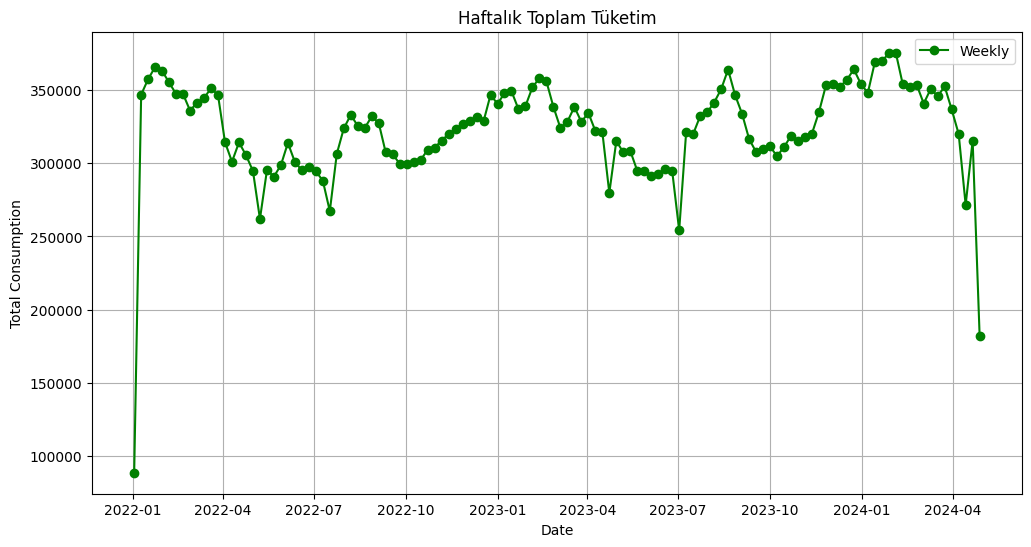

In [21]:
daily_data = df['Total Consumption'].resample('D').sum()
weekly_data = df['Total Consumption'].resample('W').sum()
monthly_data = df['Total Consumption'].resample('M').sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data, marker='o', linestyle='-', color='b', label='Daily')
plt.title('Günlük Toplam Tüketim')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data, marker='o', linestyle='-', color='g', label='Weekly')
plt.title('Haftalık Toplam Tüketim')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data, marker='o', linestyle='-', color='r', label='Monthly')
plt.title('Aylık Toplam Tüketim')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
df.drop(columns = ["Average Temperature", "Season"], inplace = True)
df.rename(columns = {"Total Consumption": "Consumption"}, inplace = True)

In [23]:
Q1 = df['Consumption'].quantile(0.25)
Q3 = df['Consumption'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Consumption'] >= lower_bound) & (df['Consumption'] <= upper_bound)]

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Consumption']])
scaled_data[1:3]

array([[0.46244486],
       [0.78591509]])

In [25]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]


def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


time_step = 1
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [26]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))
model_lstm.summary()

/Users/adnanisikgoz/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_lstm.fit(X_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - loss: 0.0533
Epoch 2/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.0150
Epoch 3/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.0145
Epoch 4/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.0139
Epoch 5/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0143


In [28]:
train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)

train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

import math
from sklearn.metrics import mean_squared_error

train_rmse_lstm = math.sqrt(mean_squared_error(y_train[0], train_predict_lstm[:,0]))
test_rmse_lstm = math.sqrt(mean_squared_error(y_test[0], test_predict_lstm[:,0]))
print(f'Train RMSE (LSTM): {train_rmse_lstm}')
print(f'Test RMSE (LSTM): {test_rmse_lstm}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
Train RMSE (LSTM): 2606.8013649684567
Test RMSE (LSTM): 3223.8957023042367


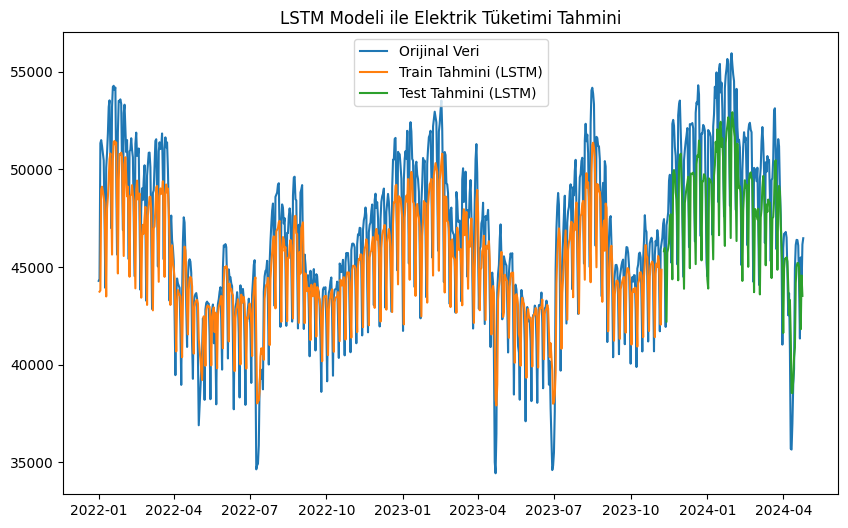

In [29]:
look_back = time_step
train_predict_plot_lstm = np.empty_like(scaled_data)
train_predict_plot_lstm[:, :] = np.nan
train_predict_plot_lstm[look_back:len(train_predict_lstm)+look_back, :] = train_predict_lstm

test_predict_plot_lstm = np.empty_like(scaled_data)
test_predict_plot_lstm[:, :] = np.nan
test_predict_plot_lstm[len(train_predict_lstm)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict_lstm

plt.figure(figsize=(10, 6))
plt.plot(df.index, scaler.inverse_transform(scaled_data), label='Orijinal Veri')
plt.plot(df.index, train_predict_plot_lstm, label='Train Tahmini (LSTM)')
plt.plot(df.index, test_predict_plot_lstm, label='Test Tahmini (LSTM)')
plt.title('LSTM Modeli ile Elektrik Tüketimi Tahmini')
plt.legend()
plt.show()

Train Score (XGBoost): 1915.8776019454783 RMSE
Test Score (XGBoost): 2951.825709085845 RMSE


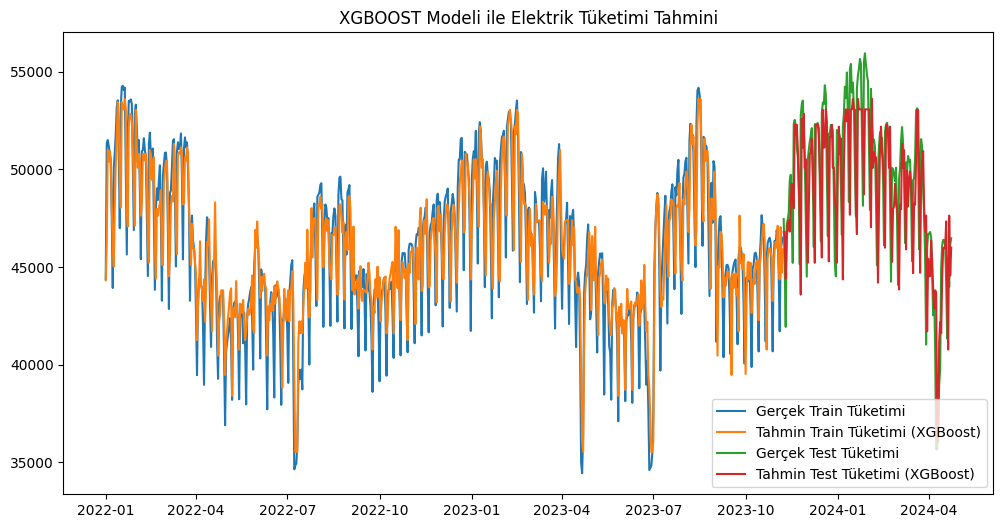

In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Consumption']])

train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 1
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
model_xgb.fit(X_train, y_train)

train_predict_xgb = model_xgb.predict(X_train)
test_predict_xgb = model_xgb.predict(X_test)

train_predict_xgb = scaler.inverse_transform(train_predict_xgb.reshape(-1, 1))
test_predict_xgb = scaler.inverse_transform(test_predict_xgb.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

train_score_xgb = np.sqrt(mean_squared_error(y_train, train_predict_xgb))
test_score_xgb = np.sqrt(mean_squared_error(y_test, test_predict_xgb))

print(f'Train Score (XGBoost): {train_score_xgb} RMSE')
print(f'Test Score (XGBoost): {test_score_xgb} RMSE')

plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(y_train)], y_train, label='Gerçek Train Tüketimi')
plt.plot(df.index[:len(y_train)], train_predict_xgb, label='Tahmin Train Tüketimi (XGBoost)')
plt.plot(df.index[len(y_train):len(y_train) + len(y_test)], y_test, label='Gerçek Test Tüketimi')
plt.plot(df.index[len(y_train):len(y_train) + len(y_test)], test_predict_xgb, label='Tahmin Test Tüketimi (XGBoost)')
plt.title('XGBOOST Modeli ile Elektrik Tüketimi Tahmini')
plt.legend()
plt.show()

/Users/adnanisikgoz/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train Score (Random Forest): 23403352.8379308 RMSE
Test Score (Random Forest): 63716484.756737754 RMSE


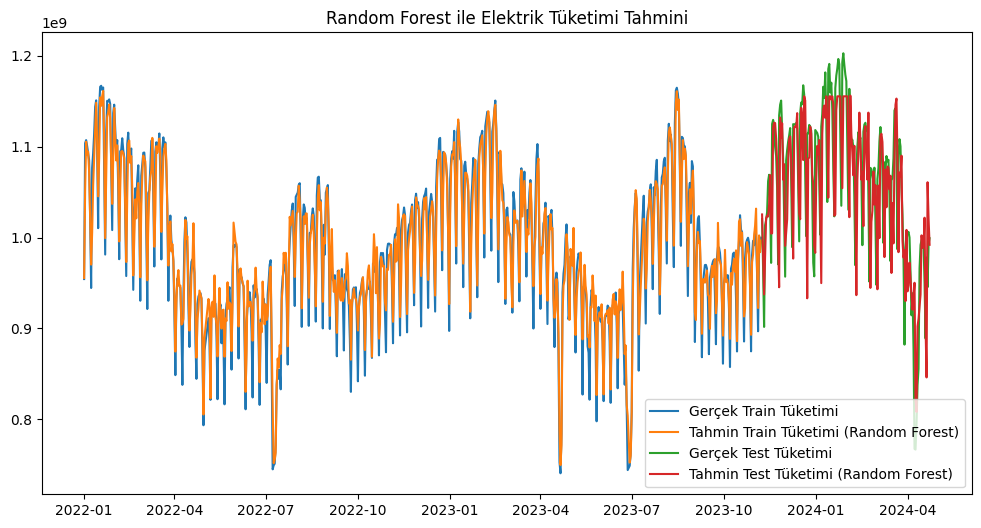

In [31]:
model_rf = RandomForestRegressor(n_estimators=1000, random_state=42)
model_rf.fit(X_train, y_train)

train_predict_rf = model_rf.predict(X_train)
test_predict_rf = model_rf.predict(X_test)

train_predict_rf = scaler.inverse_transform(train_predict_rf.reshape(-1, 1))
test_predict_rf = scaler.inverse_transform(test_predict_rf.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

train_score_rf = np.sqrt(mean_squared_error(y_train, train_predict_rf))
test_score_rf = np.sqrt(mean_squared_error(y_test, test_predict_rf))

print(f'Train Score (Random Forest): {train_score_rf} RMSE')
print(f'Test Score (Random Forest): {test_score_rf} RMSE')

plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(y_train)], y_train, label='Gerçek Train Tüketimi')
plt.plot(df.index[:len(y_train)], train_predict_rf, label='Tahmin Train Tüketimi (Random Forest)')

plt.plot(df.index[len(y_train):len(y_train) + len(y_test)], y_test, label='Gerçek Test Tüketimi')
plt.plot(df.index[len(y_train):len(y_train) + len(y_test)], test_predict_rf, label='Tahmin Test Tüketimi (Random Forest)')
plt.title('Random Forest ile Elektrik Tüketimi Tahmini')
plt.legend()
plt.show()


In [32]:

model_ctb = CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=6, loss_function='RMSE', verbose=0)
model_ctb.fit(X_train, y_train)

train_predict_ctb = model_ctb.predict(X_train)
test_predict_ctb = model_ctb.predict(X_test)

train_predict_ctb = scaler.inverse_transform(train_predict_ctb.reshape(-1, 1))
test_predict_ctb = scaler.inverse_transform(test_predict_ctb.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

train_score_ctb = np.sqrt(mean_squared_error(y_train, train_predict_ctb))
test_score_ctb = np.sqrt(mean_squared_error(y_test, test_predict_ctb))

print(f'Train Score (CatBoost): {train_score_ctb} RMSE')
print(f'Test Score (CatBoost): {test_score_ctb} RMSE')

plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(y_train)], y_train, label='Gerçek Train Tüketimi')
plt.plot(df.index[:len(y_train)], train_predict_ctb, label='Tahmin Train Tüketimi (CatBoost)')

plt.plot(df.index[len(y_train):len(y_train) + len(y_test)], y_test, label='Gerçek Test Tüketimi')
plt.plot(df.index[len(y_train):len(y_train) + len(y_test)], test_predict_ctb, label='Tahmin Test Tüketimi (CatBoost)')
plt.title('CatBoost ile Elektrik Tüketimi Tahmini')
plt.legend()
plt.show()

Train Score (CatBoost): 1042594254027.9487 RMSE
Test Score (CatBoost): 1317504861195.2207 RMSE


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=

/Users/adnanisikgoz/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
539 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/adnanisikgoz/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/adnanisikgoz/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/adnanisikgoz/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 666, in _validate_params

Epoch 1/5


/Users/adnanisikgoz/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - loss: 0.0574
Epoch 2/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 0.0142
Epoch 3/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.0127
Epoch 4/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.0137
Epoch 5/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.0123
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
Train RMSE (XGBoost): 2182.6948385109854
Test RMSE (XGBoost): 2907.520292136955
Train RMSE (Random Forest): 2046.5880414127278
Test RMSE (Random Forest): 2885.092699268448
Train RMSE (CatBoost): 2276.3553038942086
Test RMSE (CatBoost): 2846.1567371897368
Train RMSE (LSTM): 2484.3496286703257
Test RMSE (LSTM): 2980.6581432511257


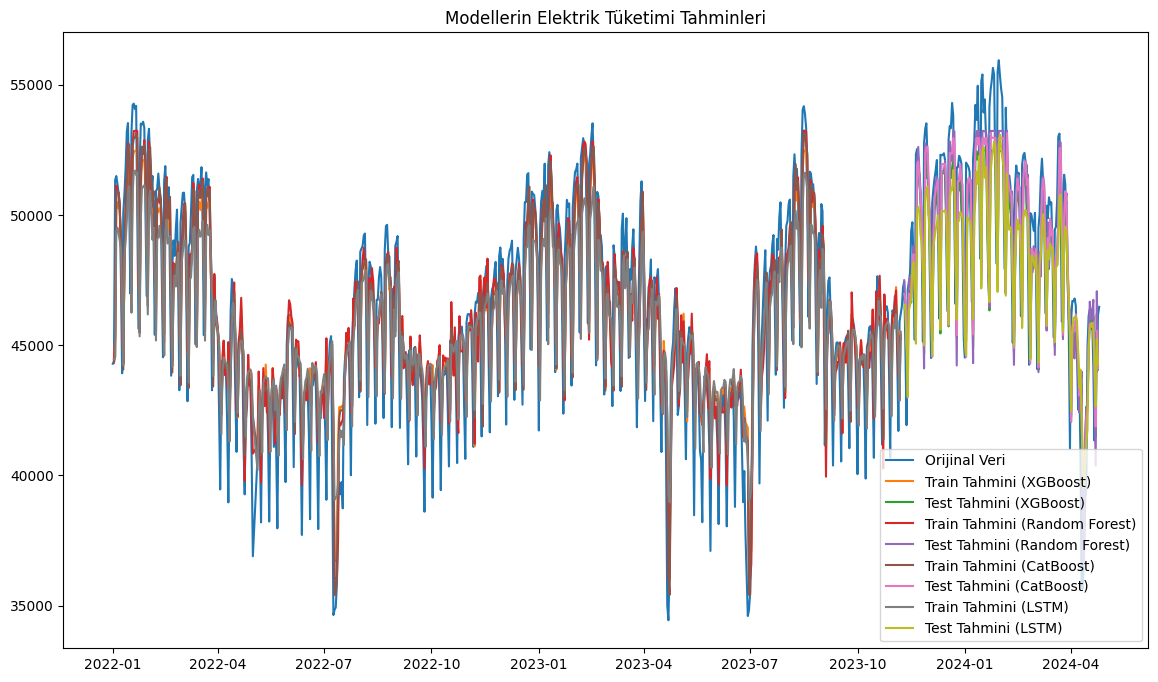

In [33]:
Q1 = df['Consumption'].quantile(0.25)
Q3 = df['Consumption'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Consumption'] >= lower_bound) & (df['Consumption'] <= upper_bound)]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Consumption']])

train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 1
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

dtrain = DMatrix(X_train, label=y_train)
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}
cv_results = cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=50,
    metrics="rmse",
    as_pandas=True,
    seed=42
)
best_num_boost_round = cv_results.shape[0]

model_xgb = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=best_num_boost_round
)
model_xgb.fit(X_train, y_train)
train_predict_xgb = model_xgb.predict(X_train)
test_predict_xgb = model_xgb.predict(X_test)
train_predict_xgb = scaler.inverse_transform(train_predict_xgb.reshape(-1, 1))
test_predict_xgb = scaler.inverse_transform(test_predict_xgb.reshape(-1, 1))

param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

train_predict_rf = best_rf.predict(X_train)
test_predict_rf = best_rf.predict(X_test)
train_predict_rf = scaler.inverse_transform(train_predict_rf.reshape(-1, 1))
test_predict_rf = scaler.inverse_transform(test_predict_rf.reshape(-1, 1))

model_ctb = CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=6, loss_function='RMSE', verbose=0)
model_ctb.fit(X_train, y_train)
train_predict_ctb = model_ctb.predict(X_train)
test_predict_ctb = model_ctb.predict(X_test)
train_predict_ctb = scaler.inverse_transform(train_predict_ctb.reshape(-1, 1))
test_predict_ctb = scaler.inverse_transform(test_predict_ctb.reshape(-1, 1))

X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train, batch_size=1, epochs=5)
train_predict_lstm = model_lstm.predict(X_train_lstm)
test_predict_lstm = model_lstm.predict(X_test_lstm)
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)

y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

train_rmse_xgb = math.sqrt(mean_squared_error(y_train[0], train_predict_xgb[:,0]))
test_rmse_xgb = math.sqrt(mean_squared_error(y_test[0], test_predict_xgb[:,0]))
train_rmse_rf = math.sqrt(mean_squared_error(y_train[0], train_predict_rf[:,0]))
test_rmse_rf = math.sqrt(mean_squared_error(y_test[0], test_predict_rf[:,0]))
train_rmse_ctb = math.sqrt(mean_squared_error(y_train[0], train_predict_ctb[:,0]))
test_rmse_ctb = math.sqrt(mean_squared_error(y_test[0], test_predict_ctb[:,0]))
train_rmse_lstm = math.sqrt(mean_squared_error(y_train[0], train_predict_lstm[:,0]))
test_rmse_lstm = math.sqrt(mean_squared_error(y_test[0], test_predict_lstm[:,0]))

print(f'Train RMSE (XGBoost): {train_rmse_xgb}')
print(f'Test RMSE (XGBoost): {test_rmse_xgb}')
print(f'Train RMSE (Random Forest): {train_rmse_rf}')
print(f'Test RMSE (Random Forest): {test_rmse_rf}')
print(f'Train RMSE (CatBoost): {train_rmse_ctb}')
print(f'Test RMSE (CatBoost): {test_rmse_ctb}')
print(f'Train RMSE (LSTM): {train_rmse_lstm}')
print(f'Test RMSE (LSTM): {test_rmse_lstm}')

plt.figure(figsize=(14, 8))
plt.plot(df.index, scaler.inverse_transform(scaled_data), label='Orijinal Veri')
plt.plot(df.index[time_step:len(train_predict_xgb)+time_step], train_predict_xgb, label='Train Tahmini (XGBoost)')
plt.plot(df.index[len(train_predict_xgb)+(time_step*2)+1:len(train_predict_xgb)+(time_step*2)+1+len(test_predict_xgb)], test_predict_xgb, label='Test Tahmini (XGBoost)')
plt.plot(df.index[time_step:len(train_predict_rf)+time_step], train_predict_rf, label='Train Tahmini (Random Forest)')
plt.plot(df.index[len(train_predict_rf)+(time_step*2)+1:len(train_predict_rf)+(time_step*2)+1+len(test_predict_rf)], test_predict_rf, label='Test Tahmini (Random Forest)')
plt.plot(df.index[time_step:len(train_predict_ctb)+time_step], train_predict_ctb, label='Train Tahmini (CatBoost)')
plt.plot(df.index[len(train_predict_ctb)+(time_step*2)+1:len(train_predict_ctb)+(time_step*2)+1+len(test_predict_ctb)], test_predict_ctb, label='Test Tahmini (CatBoost)')
plt.plot(df.index[time_step:len(train_predict_lstm)+time_step], train_predict_lstm, label='Train Tahmini (LSTM)')
plt.plot(df.index[len(train_predict_lstm)+(time_step*2)+1:len(train_predict_lstm)+(time_step*2)+1+len(test_predict_lstm)], test_predict_lstm, label='Test Tahmini (LSTM)')
plt.title('Modellerin Elektrik Tüketimi Tahminleri')
plt.legend()
plt.show()

In [34]:
train_r2_xgb = r2_score(y_train[0], train_predict_xgb[:, 0])
test_r2_xgb = r2_score(y_test[0], test_predict_xgb[:, 0])

train_r2_rf = r2_score(y_train[0], train_predict_rf[:, 0])
test_r2_rf = r2_score(y_test[0], test_predict_rf[:, 0])

train_r2_ctb = r2_score(y_train[0], train_predict_ctb[:, 0])
test_r2_ctb = r2_score(y_test[0], test_predict_ctb[:, 0])

train_r2_lstm = r2_score(y_train[0], train_predict_lstm[:, 0])
test_r2_lstm = r2_score(y_test[0], test_predict_lstm[:, 0])

print(f'Train R² (XGBoost): {train_r2_xgb}')
print(f'Test R² (XGBoost): {test_r2_xgb}')
print(f'Train R² (Random Forest): {train_r2_rf}')
print(f'Test R² (Random Forest): {test_r2_rf}')
print(f'Train R² (CatBoost): {train_r2_ctb}')
print(f'Test R² (CatBoost): {test_r2_ctb}')
print(f'Train R² (LSTM): {train_r2_lstm}')
print(f'Test R² (LSTM): {test_r2_lstm}')

Train R² (XGBoost): 0.6816185325816455
Test R² (XGBoost): 0.46448503222172965
Train R² (Random Forest): 0.7200873012775915
Test R² (Random Forest): 0.47271471855375324
Train R² (CatBoost): 0.6537084960716903
Test R² (CatBoost): 0.4868507116916726
Train R² (LSTM): 0.5875349379348774
Test R² (LSTM): 0.43720472458188675


In [35]:
train_mse_xgb = mean_squared_error(y_train[0], train_predict_xgb[:, 0])
test_mse_xgb = mean_squared_error(y_test[0], test_predict_xgb[:, 0])
train_mae_xgb = mean_absolute_error(y_train[0], train_predict_xgb[:, 0])
test_mae_xgb = mean_absolute_error(y_test[0], test_predict_xgb[:, 0])

train_mse_rf = mean_squared_error(y_train[0], train_predict_rf[:, 0])
test_mse_rf = mean_squared_error(y_test[0], test_predict_rf[:, 0])
train_mae_rf = mean_absolute_error(y_train[0], train_predict_rf[:, 0])
test_mae_rf = mean_absolute_error(y_test[0], test_predict_rf[:, 0])

train_mse_ctb = mean_squared_error(y_train[0], train_predict_ctb[:, 0])
test_mse_ctb = mean_squared_error(y_test[0], test_predict_ctb[:, 0])
train_mae_ctb = mean_absolute_error(y_train[0], train_predict_ctb[:, 0])
test_mae_ctb = mean_absolute_error(y_test[0], test_predict_ctb[:, 0])

train_mse_lstm = mean_squared_error(y_train[0], train_predict_lstm[:, 0])
test_mse_lstm = mean_squared_error(y_test[0], test_predict_lstm[:, 0])
train_mae_lstm = mean_absolute_error(y_train[0], train_predict_lstm[:, 0])
test_mae_lstm = mean_absolute_error(y_test[0], test_predict_lstm[:, 0])

print(f'Train MSE (XGBoost): {train_mse_xgb}')
print(f'Test MSE (XGBoost): {test_mse_xgb}')
print(f'Train MAE (XGBoost): {train_mae_xgb}')
print(f'Test MAE (XGBoost): {test_mae_xgb}')

print(f'Train MSE (Random Forest): {train_mse_rf}')
print(f'Test MSE (Random Forest): {test_mse_rf}')
print(f'Train MAE (Random Forest): {train_mae_rf}')
print(f'Test MAE (Random Forest): {test_mae_rf}')

print(f'Train MSE (CatBoost): {train_mse_ctb}')
print(f'Test MSE (CatBoost): {test_mse_ctb}')
print(f'Train MAE (CatBoost): {train_mae_ctb}')
print(f'Test MAE (CatBoost): {test_mae_ctb}')

print(f'Train MSE (LSTM): {train_mse_lstm}')
print(f'Test MSE (LSTM): {test_mse_lstm}')
print(f'Train MAE (LSTM): {train_mae_lstm}')
print(f'Test MAE (LSTM): {test_mae_lstm}')

Train MSE (XGBoost): 4764156.758062496
Test MSE (XGBoost): 8453674.249188164
Train MAE (XGBoost): 1640.7529622780737
Test MAE (XGBoost): 2233.7308836622906
Train MSE (Random Forest): 4188522.6112535847
Test MSE (Random Forest): 8323759.8833721
Train MAE (Random Forest): 1511.1621259668386
Test MAE (Random Forest): 2110.5662506258163
Train MSE (CatBoost): 5181793.469567294
Test MSE (CatBoost): 8100608.172650527
Train MAE (CatBoost): 1680.1099862404933
Test MAE (CatBoost): 2122.7053667111777
Train MSE (LSTM): 6171993.0774743855
Test MSE (LSTM): 8884322.96692925
Train MAE (LSTM): 1959.6077794070486
Test MAE (LSTM): 2394.586773015397


In [36]:
last_data = scaled_data[-time_step:]

xgb_prediction = model_xgb.predict(last_data.reshape(1, -1))
xgb_prediction = scaler.inverse_transform(xgb_prediction.reshape(-1, 1))[0][0]

rf_prediction = best_rf.predict(last_data.reshape(1, -1))
rf_prediction = scaler.inverse_transform(rf_prediction.reshape(-1, 1))[0][0]

ctb_prediction = model_ctb.predict(last_data.reshape(1, -1))
ctb_prediction = scaler.inverse_transform(ctb_prediction.reshape(-1, 1))[0][0]

lstm_prediction = model_lstm.predict(last_data.reshape(1, time_step, 1))
lstm_prediction = scaler.inverse_transform(lstm_prediction)[0][0]

print(f"XGBoost'un bir sonraki gün için tüketim tahmini: {xgb_prediction:.2f}")
print(f"Random Forest'ın bir sonraki gün için tüketim tahmini: {rf_prediction:.2f}")
print(f"CatBoost'un bir sonraki gün için tüketim tahmini: {ctb_prediction:.2f}")
print(f"LSTM'in bir sonraki gün için tüketim tahmini: {lstm_prediction:.2f}")

predictions = [xgb_prediction, rf_prediction, ctb_prediction, lstm_prediction]
average_prediction = np.mean(predictions)
print(f"Dört modelin ortalama tahmini: {average_prediction:.2f}")

weights = [0.2, 0.2, 0.3, 0.3]  
weighted_prediction = np.average(predictions, weights=weights)
print(f"Dört modelin ağırlıklı ortalama tahmini: {weighted_prediction:.2f}")

if len(df) > len(scaled_data):
    next_day_actual = df['Consumption'].iloc[len(scaled_data)]
    print(f"Bir sonraki günün gerçek tüketim değeri: {next_day_actual:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
XGBoost'un bir sonraki gün için tüketim tahmini: 45532.01
Random Forest'ın bir sonraki gün için tüketim tahmini: 45322.33
CatBoost'un bir sonraki gün için tüketim tahmini: 45624.96
LSTM'in bir sonraki gün için tüketim tahmini: 45897.33
Dört modelin ortalama tahmini: 45594.16
Dört modelin ağırlıklı ortalama tahmini: 45627.56


In [37]:
from sklearn.metrics import mean_absolute_percentage_error

def calculate_mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred) * 100

train_mape_xgb = calculate_mape(y_train[0], train_predict_xgb[:, 0])
test_mape_xgb = calculate_mape(y_test[0], test_predict_xgb[:, 0])

train_mape_rf = calculate_mape(y_train[0], train_predict_rf[:, 0])
test_mape_rf = calculate_mape(y_test[0], test_predict_rf[:, 0])

train_mape_ctb = calculate_mape(y_train[0], train_predict_ctb[:, 0])
test_mape_ctb = calculate_mape(y_test[0], test_predict_ctb[:, 0])

train_mape_lstm = calculate_mape(y_train[0], train_predict_lstm[:, 0])
test_mape_lstm = calculate_mape(y_test[0], test_predict_lstm[:, 0])

print(f'Train MAPE (XGBoost): {train_mape_xgb:.2f}%')
print(f'Test MAPE (XGBoost): {test_mape_xgb:.2f}%')
print(f'Train MAPE (Random Forest): {train_mape_rf:.2f}%')
print(f'Test MAPE (Random Forest): {test_mape_rf:.2f}%')
print(f'Train MAPE (CatBoost): {train_mape_ctb:.2f}%')
print(f'Test MAPE (CatBoost): {test_mape_ctb:.2f}%')
print(f'Train MAPE (LSTM): {train_mape_lstm:.2f}%')
print(f'Test MAPE (LSTM): {test_mape_lstm:.2f}%')

Train MAPE (XGBoost): 3.65%
Test MAPE (XGBoost): 4.53%
Train MAPE (Random Forest): 3.35%
Test MAPE (Random Forest): 4.31%
Train MAPE (CatBoost): 3.73%
Test MAPE (CatBoost): 4.34%
Train MAPE (LSTM): 4.34%
Test MAPE (LSTM): 4.82%


In [38]:
train_mape_scores = {
    'XGBoost': 3.65,
    'Random Forest': 3.35,
    'CatBoost': 3.73,
    'LSTM': 4.82
}

test_mape_scores = {
    'XGBoost': 4.53,
    'Random Forest': 4.31,
    'CatBoost': 4.34,
    'LSTM': 4.49
}

models = list(train_mape_scores.keys())
train_mape = list(train_mape_scores.values())
test_mape = list(test_mape_scores.values())

x = range(len(models))  

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
ax.bar(x, train_mape, width=bar_width, label='Train MAPE', color='b', alpha=0.7)
ax.bar([p + bar_width for p in x], test_mape, width=bar_width, label='Test MAPE', color='r', alpha=0.7)

ax.set_xlabel('Modeller')
ax.set_ylabel('MAPE (%)')
ax.set_title('Modellerin Eğitim ve Test MAPE Skorları')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(models)

for i in range(len(models)):
    ax.text(x[i], train_mape[i] + 0.1, f'{train_mape[i]:.2f}%', ha='center', va='bottom', color='blue')
    ax.text(x[i] + bar_width, test_mape[i] + 0.1, f'{test_mape[i]:.2f}%', ha='center', va='bottom', color='red')

ax.legend()

fig.tight_layout()

plt.show()